In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

Dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

#Data

## Download Data

In [5]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dat

##Prepare Data

In [6]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba",
    label_mode=None,
    image_size=(IM_SHAPE[0], IM_SHAPE[1]),
    batch_size=BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [8]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [9]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [10]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size=1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


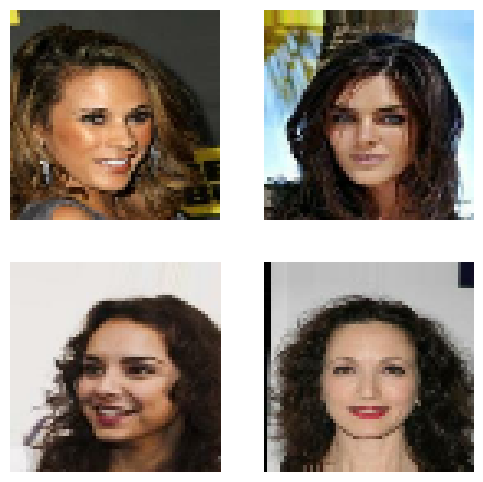

In [12]:
plt.figure(figsize= (6, 6))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2, 2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# Modeling

In [30]:
generator=tf.keras.Sequential([
    Input(shape=(LATENT_DIM,)),
    Dense(4*4*LATENT_DIM),
    Reshape((4, 4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size=4, strides=2, activation=tf.keras.activations.tanh, padding='same'),
], name='generator')

In [31]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 8, 8, 512)         819712    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 8, 8, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 256)       20

In [32]:
discriminator=tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size=4, strides=2, padding='same'),

    Flatten(),
    Dense(1, activation='sigmoid')

], name='discriminator')

In [24]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_8 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 batch_normalization_9 (Bat  (None, 8, 8, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 1)         

In [33]:
class ShowImage(tf.keras.callbacks.Callback):
  def __init__(self, latent_dim=100):
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    n=6
    k=0
    out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
    plt.figure(figsize=(16,16))
    for i in range(n):
      for j in range(n):
        ax=plt.subplot(n, n, k+1)
        plt.imshow((out[k]+1)/2)
        plt.axis('off')
        k+=1
      plt.savefig("generated/gen_images_epoch_{}.png".format(epoch))

In [43]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [44]:
gan=GAN(discriminator, generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [45]:
!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
history=gan.fit(train_dataset, epochs=EPOCHS, callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/20
      6/Unknown - 10s 183ms/step - d_loss: 1.4819 - g_loss: 0.6486

1582/1582 [==============================] - 287s 176ms/step - d_loss: 0.7346 - g_loss: 1.7390
Epoch 2/20
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.2605 - g_loss: 0.7939
Epoch 3/20
1582/1582 [==============================] - 286s 181ms/step - d_loss: 1.2117 - g_loss: 0.8514
Epoch 4/20
1582/1582 [==============================] - 286s 180ms/step - d_loss: 1.1929 - g_loss: 0.8668
Epoch 5/20
1582/1582 [==============================] - 287s 181ms/step - d_loss: 1.2004 - g_loss: 0.8521
Epoch 6/20
1582/1582 [==============================] - 288s 182ms/step - d_loss: 1.2088 - g_loss: 0.8444
Epoch 7/20
1582/1582 [==============================] - 285s 180ms/step - d_loss: 1.2191 - g_loss: 0.8321
Epoch 8/20
1582/1582 [==============================] - 285s 180ms/step - d_loss: 1.2000 - g_loss: 0.8461
Epoch 9/20
1582/1582 [==============================] - 283s 179ms/step - d_loss: 1.2056 - g_loss: 0.8436
Epoch 10/20
1582/1582 [==============================] - 